In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Function for cropping and then warping the image
def warp_image(img, new_left, new_right):
    # Get the dimensions of the image
    image_h = img.shape[0]
    image_w = img.shape[1]

    # Set the car position to the center of the window
    car_pos = ((new_right - new_left) / 2) + new_left
    car_pos = np.array([car_pos, image_h-1], dtype=int)

    # Warp the image to get an areal view
    src = np.float32([[0, image_h], [image_w, image_h], [0,0], [image_w, 0]])
    dst = np.float32([[new_left,image_h], [new_right, image_h], [0,0], [image_w, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)  # Use to unwarp the image

    img_warped = cv2.warpPerspective(img, M, (image_w, image_h))

    return img_warped, car_pos

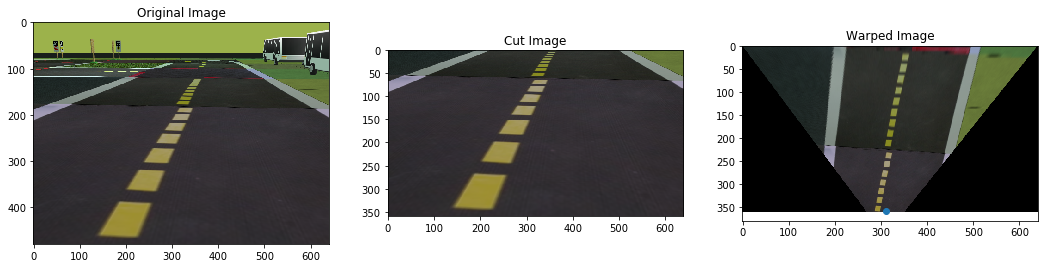

In [3]:
# Load the image
image_file = 'duckietown_images/1.png'
img = cv2.imread(image_file)

fig, ax = plt.subplots(1,3, figsize=(18,12))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')

# Cut the image
img = img[120::, :]
ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].set_title('Cut Image')

# Warp the image
new_left = 270
new_right = 350
img_warped, car_pos = warp_image(img, new_left, new_right)

# Show the warped image
ax[2].imshow(cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB))
ax[2].scatter(car_pos[0], car_pos[1])
ax[2].set_title('Warped Image')

plt.show()


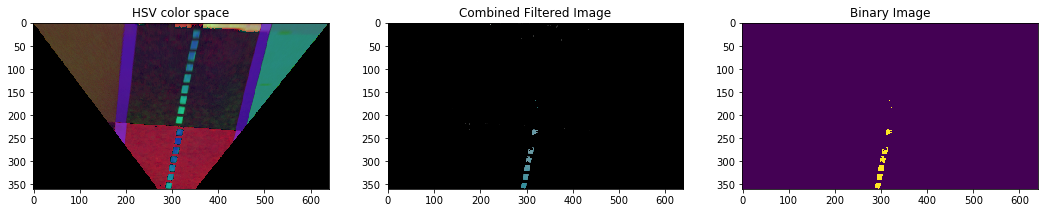

In [4]:
# Filter out lane lines using color

# Transform image to HSV color space
img_hsv = cv2.cvtColor(img_warped, cv2.COLOR_BGR2HSV)

fig, ax = plt.subplots(1,3, figsize=(18,12))
ax[0].imshow(img_hsv)
ax[0].set_title('HSV color space')

# Filter out everything but yellow (dotted lines) and white (side lines)
yellow_lower = np.array([20, 75, 100])
yellow_upper = np.array([30, 255, 255])
white_lower = np.array([0,0,1])
white_upper = np.array([120,5,255])

img_yellow = cv2.inRange(img_hsv, yellow_lower, yellow_upper)
img_white = cv2.inRange(img_hsv, white_lower, white_upper)
combined_filtered = img_yellow + img_white

# Show image with filtered yellow and white lines
img_filtered = cv2.bitwise_and(img_warped, img_warped, mask=combined_filtered)
ax[1].imshow(img_filtered)
ax[1].set_title('Combined Filtered Image')


# Fid the points on the lane lines to a polynomial
# Convert to binary image
img_yellow_bin = img_yellow / 255
ax[2].imshow(img_yellow_bin)
ax[2].set_title('Binary Image')

plt.show()

Fitted polynomial:
 
-5.063 x + 1835
[310 359]
Distance from Center = 18.51
Angle from Straight = 0.19


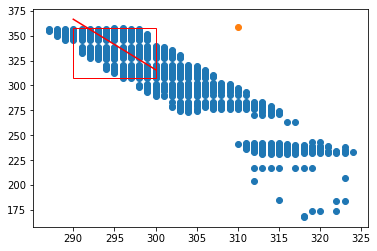

In [5]:
# Get the points in the binary image that are 1
data = np.argwhere(img_yellow_bin == 1)

# Define window to look for points
window_H = 50
window_W = 10

# Go down until finding a row with ones
i = 0
start_pos = 0
while True:
    row = img_yellow_bin[car_pos[1]-i, 0:car_pos[0]]
    row = np.where(row)
    if row[0].size != 0:
        start_pos = [car_pos[0], car_pos[1]-i]
        break
    else:
        i += 1


# Get the middle point for each row
points = []
for i in range(window_H):
    row = img_yellow_bin[start_pos[1]-i, ::]
    row = np.where(row)
    if row[0].size != 0:
        middle = int(np.mean(row))
        points.append([start_pos[1]-i, middle])

# Convert to numpy array
points = np.asarray(points)

# Find a 1-degree fit to the points
p = np.polyfit(points[:, 1], points[:, 0], 1)
p = np.poly1d(p)
print("Fitted polynomial:")
print(p)

# Parameters for drawing a box
window_center = points[0,1]
window_center = np.array([window_center, start_pos[1]])
x = int(window_center[0] - 0.5*window_W)
y = int(window_center[1] - window_H)

# Calculate distance from center of lane
print(car_pos)
distance_from_center = car_pos[0] - (car_pos[1] - p[0]) / p[1]

# Check what direction the angle should be
# If the slope of the polynomial is negative, turn left
# If the slope of the polynomial is positive, turn right
angle_from_straight = math.atan2(1, abs(p[1]))

print("Distance from Center = {:.2f}".format(distance_from_center))
print("Angle from Straight = {:.2f}".format(angle_from_straight))


# Plot
fig, ax = plt.subplots(1)
ax.scatter(data[:, 1], data[:, 0])
ax.scatter(car_pos[0], car_pos[1])
rect = patches.Rectangle((x, y), window_W, window_H,
                         linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
x_axis = np.linspace(x, x+window_W, 100)
ax.plot(x_axis, p(x_axis), color='red')
plt.show()
